Class balance: [50 50] (counts for [setosa, versicolor])
Best params: {'svm__C': 0.1, 'svm__gamma': 'scale'}
Best CV F1: 1.0

=== Test Metrics ===
Accuracy : 1.0
Precision: 1.0
Recall   : 1.0
F1-score : 1.0
ROC-AUC  : 1.0

Classification report:
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        13
  versicolor       1.00      1.00      1.00        12

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25



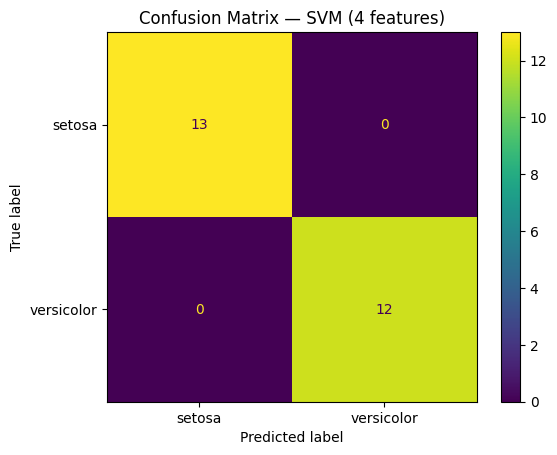

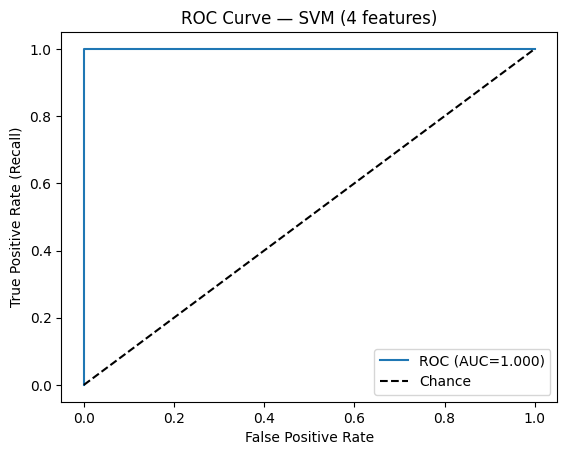

In [3]:
# ============================
# SVM: Iris Setosa vs Versicolor
# ============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, ConfusionMatrixDisplay, classification_report
)

# ---------- 1) Load data ----------
df = pd.read_csv("Model_5_data.csv")

# Expecting columns:
# sepal length (standardized), sepal width (standardized),
# petal length (standardized), petal width (standardized), species (0=setosa, 1=versicolor)
X = df.drop(columns=["species"])
y = df["species"].astype(int)

print("Class balance:", np.bincount(y), "(counts for [setosa, versicolor])")

# ---------- 2) Train / Test split ----------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# ---------- 3) Model pipeline (scaling + SVM) ----------
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="rbf", probability=True, random_state=42))
])

# quick hyperparameter search (kept small for speed)
param_grid = {
    "svm__C": [0.1, 1, 10],
    "svm__gamma": ["scale", 0.1, 0.01]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="f1",        
    cv=cv,
    n_jobs=-1
)
grid.fit(X_train, y_train)
best_model = grid.best_estimator_

print("Best params:", grid.best_params_)
print("Best CV F1:", round(grid.best_score_, 3))

# ---------- 4) Evaluate on test set ----------
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec  = recall_score(y_test, y_pred)
f1   = f1_score(y_test, y_pred)
auc  = roc_auc_score(y_test, y_prob)

print("\n=== Test Metrics ===")
print("Accuracy :", round(acc, 3))
print("Precision:", round(prec, 3))
print("Recall   :", round(rec, 3))
print("F1-score :", round(f1, 3))
print("ROC-AUC  :", round(auc, 3))
print("\nClassification report:\n", classification_report(y_test, y_pred, target_names=["setosa","versicolor"]))

# ---------- 5) Confusion matrix ----------
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["setosa","versicolor"])
plt.title("Confusion Matrix — SVM (4 features)")
plt.show()

# ---------- 6) ROC curve ----------
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f"ROC (AUC={auc:.3f})")
plt.plot([0, 1], [0, 1], "k--", label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve — SVM (4 features)")
plt.legend()
plt.show()

